# Идеи

1. Эмбеддинги самари и коментарии
2. Часовые пояса у пользователей
3. Порядковые номера тасков внутри проекта                     +++
4. Количество одновременно назначенных тасков у пользователя
5. Количество комментариев у таска                             +++

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
import lightgbm

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

from transformers import AutoTokenizer, AutoModel
from umap.umap_ import UMAP
import torch

%matplotlib inline

In [ ]:
TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
BERT = AutoModel.from_pretrained("cointegrated/rubert-tiny2")

In [ ]:
df_issues_train = pd.read_csv("data/train_issues.csv")
df_comment_train = pd.read_csv("data/train_comments.csv")

df_issues_test = pd.read_csv("data/test_issues.csv")
df_comment_test = pd.read_csv("data/test_comments.csv")

df_emp = pd.read_csv("data/employees.csv")

In [ ]:
df_issues_test['overall_worklogs'] = -1
df_all = pd.concat([df_issues_train, df_issues_test])
df_all_com = pd.concat([df_comment_train, df_comment_test])

In [563]:
df_all

,key,project_id,assignee_id,creator_id,overall_worklogs,day,month,hour,day_of_week,comments_count,...,assignee_min_time,assignee_max_time,assignee_mean_time,assignee_median_time,assignee_std_time,creator_min_time,creator_max_time,creator_mean_time,creator_median_time,creator_std_time
0,10678,0,93,93,1800,1,36,5,2,0,...,600.0,50400.0,9511.764706,4650.0,11111.549130,600.0,50400.0,9288.888889,7200.0,10527.156579
1,10679,0,93,93,7200,1,36,5,2,1,...,600.0,50400.0,9511.764706,4650.0,11111.549130,600.0,50400.0,9288.888889,7200.0,10527.156579
2,10680,0,93,93,14400,1,36,6,2,0,...,600.0,50400.0,9511.764706,4650.0,11111.549130,600.0,50400.0,9288.888889,7200.0,10527.156579
3,10682,0,93,93,900,1,36,6,2,0,...,600.0,50400.0,9511.764706,4650.0,11111.549130,600.0,50400.0,9288.888889,7200.0,10527.156579
4,10683,0,93,93,900,1,36,6,2,1,...,600.0,50400.0,9511.764706,4650.0,11111.549130,600.0,50400.0,9288.888889,7200.0,10527.156579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,1392,5,1,1,-1,24,33,11,4,1,...,120.0,7014000.0,24463.448498,7200.0,184313.445233,120.0,1315200.0,17086.867229,7200.0,54923.214870
1066,1402,5,1,1,-1,28,33,14,1,10,...,120.0,7014000.0,24463.448498,7200.0,184313.445233,120.0,1315200.0,17086.867229,7200.0,54923.214870
1067,1422,5,1,1,-1,6,37,13,2,0,...,120.0,7014000.0,24463.448498,7200.0,184313.445233,120.0,1315200.0,17086.867229,7200.0,54923.214870
1068,1493,5,1,1,-1,5,41,15,4,0,...,120.0,7014000.0,24463.448498,7200.0,184313.445233,120.0,1315200.0,17086.867229,7200.0,54923.214870


In [ ]:
df_comment_train[df_comment_train.issue_id == 819941]

In [561]:
def get_workers_stats(X, field):
    train_df = X[X.overall_worklogs != -1]
    stats_df = train_df.groupby(field).agg({'overall_worklogs': [min, max, np.mean, np.median, np.std]})
    stats_df.columns = [f'{field.split("_")[0]}_{i}_time' for i in stats_df.columns.droplevel(0)]
    X[stats_df.columns] = pd.merge(X, stats_df, left_on=field, right_index=True, how='left')[stats_df.columns]

In [562]:
for field in ['assignee_id', 'creator_id']:
    get_workers_stats(df_all, field)

In [ ]:
df_issues_test[df_issues_test.assignee_id == 403]

### Предобработка

In [ ]:
# ДАТА И ВРЕМЯ
def encode_date(X):
    X.created = pd.to_datetime(X.created)
    X['day'] = X.created.dt.strftime('%d').astype(int)
    X['month'] = X.created.dt.strftime('%m-%y')
    X['hour'] = X.created.dt.strftime("%H").astype(int)
    X['day_of_week'] = X.created.dt.strftime("%w").astype(int)
    X.drop('created', axis=1, inplace=True)

# КОЛИЧЕСТВО И ДЛИНА КОММЕНТАРИЕВ
def process_coments(X):
    com_df = pd.DataFrame(pd.merge(X, df_all_com, left_on="id", right_on="issue_id", how='left'))
    com_df.text = com_df.text.astype('str')
    com_df.text = com_df.text.apply(len).astype('int')
    counts = com_df.groupby('id').comment_id.count()
    lens = com_df.groupby('id').text.sum()
    X['comments_count'] = pd.merge(X, counts, left_on='id', right_index=True).comment_id
    X['comments_len'] = pd.merge(X, lens, left_on='id', right_index=True).text
    
# ИНФОРМАЦИЯ ОБ ИСПОЛНИТЕЛЕ
def get_assignee_info(X):
    df = pd.merge(X, df_emp, left_on='assignee_id', right_on='id', how='left')
    df.fillna('unknown', inplace=True)
    col_list = ['position', 'hiring_type', 'payment_type', 'passport', 'is_nda_signed', 'is_labor_contract_signed', 'is_added_to_internal_chats', 'is_added_one_to_one']
    X[col_list] = df[col_list]

# ЭМБЕДДИНГИ И КЛАСТЕРИЗАЦИЯ
morph = pymorphy2.MorphAnalyzer()
def preprocess(text: str) -> list:
    tokenized = nltk.word_tokenize(text.lower())
    normalized = [morph.parse(word)[0].normal_form for word in tokenized
                  if len(word) > 1 and word.isalpha()]
    return normalized

'''def get_clusters(X):
    text = X.summary
    embedder = SentenceTransformer('DeepPavlov/rubert-base-cased-sentence')
    embeddings = embedder.encode(text)
    embeddings = embeddings /  np.linalg.norm(embeddings, axis=1, keepdims=True)
    clustering_model = AgglomerativeClustering(n_clusters=20)#, affinity='cosine', linkage='average', distance_threshold=0.25)
    clustering_model.fit(embeddings)
    res = pd.DataFrame(clustering_model.labels_, columns=['cluster'])
    X['cluster'] = res.cluster'''
    
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

def get_bert_enc(X):
    embeddings = []
    for sentence in X['summary']:
        embeddings.append(embed_bert_cls(sentence, BERT, TOKENIZER))
    embeddings = np.array(embeddings)

    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=3,
                  random_state=42,
                  low_memory=False,
                  metric='cosine',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(embeddings).T
    for i in range(len(umap_res)):
        X[f'bert_umap_{i}'] = umap_res[i]

# КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
def make_categorical(df, col):
    df[col] = pd.Categorical(df[col])
    df[col] = df[col].astype('category').cat.codes
        
# ВСЕ ПРЕОБРАЗОВАНИЯ
def apply_technicals(X):
    encode_date(X)
    process_coments(X)
    get_assignee_info(X)
    get_bert_enc(X)
    
    cat_cols = ['project_id', 'month', 'position', 'hiring_type', 'payment_type']
    for column in cat_cols:
        make_categorical(X, column)
    
    vals = [preprocess(word) for word in X.summary]
    get_tf_idf_enc(vals, X, 'summary')
    
    X['key'] = X.key.apply(lambda x: x.split('-')[1]).astype('int')
    X['is_self_assigned'] = np.where(X.assignee_id == X.creator_id, 1, 0)
    X['len_summary'] = X['summary'].apply(len)
    X.drop(['id', 'summary'], axis=1, inplace=True)

In [ ]:
apply_technicals(df_all)

In [ ]:
df_all.head(10)

In [564]:
df_test = df_all[df_all.overall_worklogs == -1].copy()
df_test.drop('overall_worklogs', axis=1, inplace=True)
#df_test.drop(['bert_umap_0', 'bert_umap_1', 'bert_umap_2'], axis=1, inplace=True)

In [576]:
df_train = df_all[(df_all.overall_worklogs != -1) & (df_all.overall_worklogs < 2000000)].copy()
#df_train.drop('key', axis=1, inplace=True)
y = df_train.overall_worklogs
y = np.log(y+0.001)
X = df_train.drop('overall_worklogs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
params = {'learning_rate': 0.1, 
          'depth': 12, 
          'l2_leaf_reg': 5, 
          'loss_function': 'RMSE', 
          'eval_metric': 'RMSE', 
          'task_type': 'CPU', 
          'iterations': 600,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True, 
          'logging_level': 'Silent',
          'random_state': 42
         }
gbt = CatBoostRegressor(**params)#, cat_features=[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16])
gbt.fit(X_train, y_train)
print(r2_score(gbt.predict(X_train), y_train))
print(r2_score(gbt.predict(X_test), y_test))

In [ ]:
feat = pd.Series(gbt.feature_importances_, index=X_train.columns)
feat.sort_values(ascending=False)

In [577]:
lgbm = lightgbm.LGBMRegressor(num_leaves=30, n_estimators=3500, learning_rate=0.001)
lgbm = lgbm.fit(X_train, y_train,
                            eval_set=[(X_train, y_train), (X_test, y_test)],
                            eval_names=['train', 'val'], eval_metric=lgbm_r2, callbacks=[lightgbm.log_evaluation(500)])

[500]	train's l2: 1.27419	train's r2: 0.157471	val's l2: 1.31643	val's r2: 0.143039
[1000]	train's l2: 1.15795	train's r2: 0.234332	val's l2: 1.2184	val's r2: 0.206853
[1500]	train's l2: 1.08392	train's r2: 0.283279	val's l2: 1.16248	val's r2: 0.243259
[2000]	train's l2: 1.03084	train's r2: 0.318381	val's l2: 1.13116	val's r2: 0.263642
[2500]	train's l2: 0.988061	train's r2: 0.346666	val's l2: 1.11187	val's r2: 0.2762
[3000]	train's l2: 0.952313	train's r2: 0.370304	val's l2: 1.09974	val's r2: 0.284096
[3500]	train's l2: 0.921459	train's r2: 0.390705	val's l2: 1.09178	val's r2: 0.289277


In [607]:
lgbm_feat = pd.Series(lgbm.feature_importances_, index=X_train.columns)
lgbm_feat.sort_values(ascending=False)

key                           11416
comments_len                   8733
bert_umap_2                    8304
month                          7260
bert_umap_0                    6886
bert_umap_1                    6399
len_summary                    5847
assignee_median_time           4882
summary_umap_2                 4430
summary_umap_0                 4304
summary_umap_1                 4252
comments_count                 3129
day                            2883
assignee_mean_time             2801
hour                           2431
creator_median_time            2219
creator_max_time               2172
assignee_max_time              1802
creator_id                     1782
is_self_assigned               1420
assignee_id                    1411
project_id                     1232
creator_mean_time              1023
assignee_min_time               943
creator_std_time                880
creator_min_time                697
assignee_std_time               622
day_of_week                 

In [601]:
res_val_df = pd.DataFrame(np.exp(y_test))
res_val_df['pred'] = np.exp(lgbm.predict(X_test))

In [605]:
df_all.loc[5841]

key                           7.139000e+03
project_id                    1.000000e+00
assignee_id                   1.490000e+02
creator_id                    1.000000e+00
overall_worklogs              3.414000e+05
day                           1.600000e+01
month                         3.000000e+01
hour                          1.000000e+01
day_of_week                   0.000000e+00
comments_count                0.000000e+00
comments_len                  3.000000e+00
position                      4.000000e+00
hiring_type                   2.000000e+00
payment_type                  2.000000e+00
passport                      0.000000e+00
is_nda_signed                 0.000000e+00
is_labor_contract_signed      0.000000e+00
is_added_to_internal_chats    0.000000e+00
is_added_one_to_one           0.000000e+00
bert_umap_0                  -3.020073e-01
bert_umap_1                   6.870250e+00
bert_umap_2                   7.244742e+00
summary_umap_0                9.810066e+00
summary_uma

In [610]:
res_val_df.describe()

,overall_worklogs,pred
count,2397.000000,2397.000000
mean,14604.406507,8393.415941
std,33718.880108,8474.081889
min,60.001000,853.386768
25%,3000.001000,5060.987411
50%,7200.001000,6512.935430
75%,14400.001000,8538.602699
max,594600.001000,120601.168760


In [581]:
r2_score(np.exp(y_test), np.exp(lgbm.predict(X_test)))

0.13065615293514132

<AxesSubplot:xlabel='overall_worklogs', ylabel='Count'>

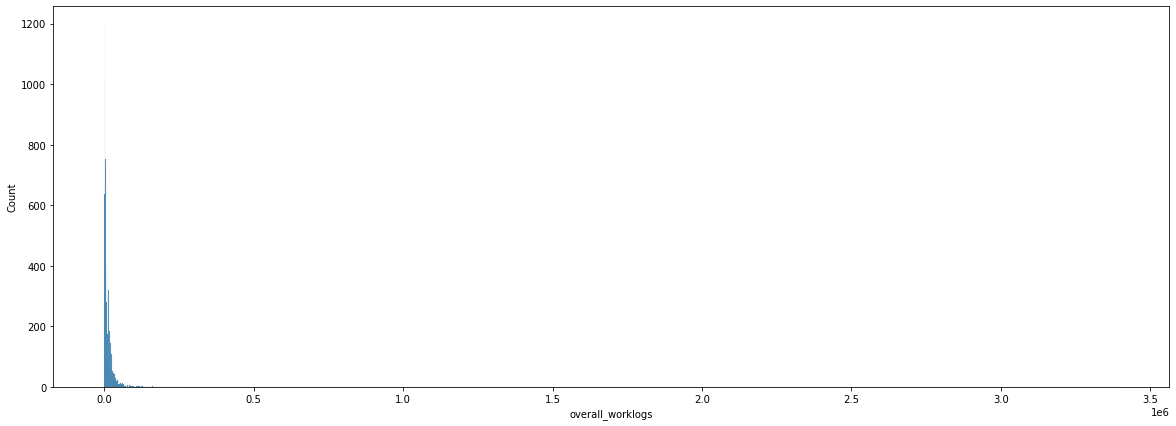

In [523]:
plt.figure(figsize=(20,7))
sns.histplot(df_train.overall_worklogs)

<AxesSubplot:ylabel='Count'>

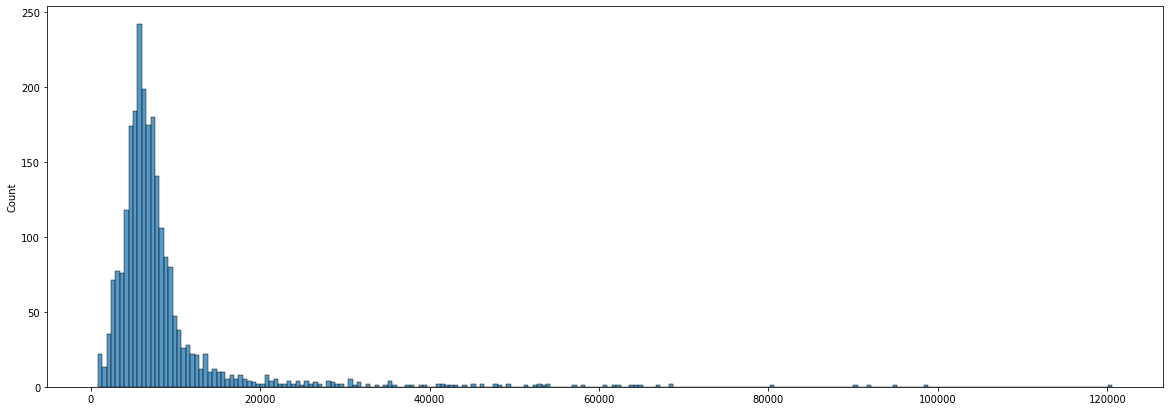

In [580]:
plt.figure(figsize=(20,7))
#sns.histplot(lgbm.predict(X_test))
sns.histplot(np.exp(lgbm.predict(X_test)))

<AxesSubplot:xlabel='overall_worklogs', ylabel='Count'>

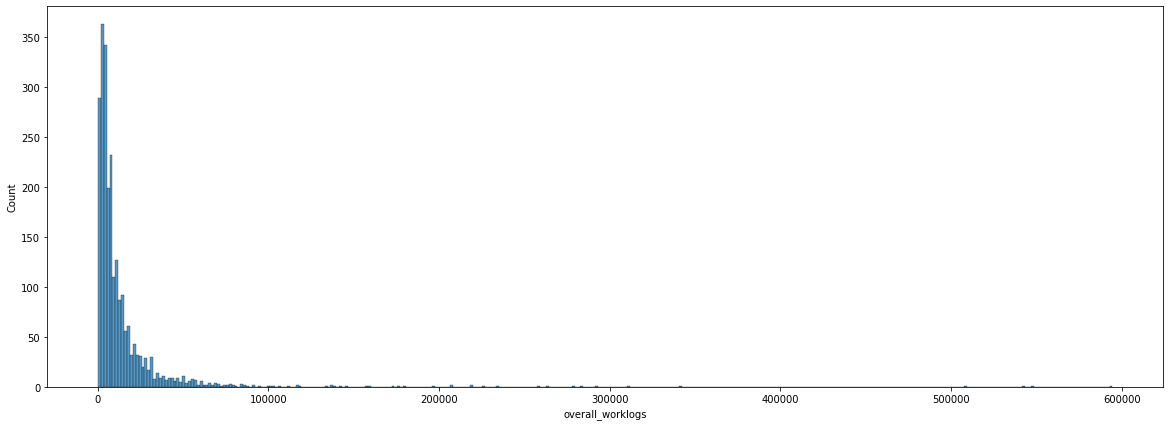

In [578]:
plt.figure(figsize=(20,7))
sns.histplot(np.exp(y_test))

In [608]:
pred = lgbm.predict(df_test)
pred = np.where(pred<0, 600, pred)
pred = np.exp(pred)

In [609]:
ind_df = pd.read_csv('data/solution_01.csv')
solution = pd.DataFrame({'overall_worklogs': pred}, index=ind_df.id)
solution.to_csv('data/solution_07.csv')

In [ ]:
def lgbm_r2(y_true, y_pred):
    return 'r2', r2_score(y_true, y_pred), True

In [ ]:
val_pred = pd.Series(lgbm.predict(X_test))
val_pred = np.where(val_pred<0, 600, val_pred)
val_pred

In [ ]:
val_pred.min()

In [ ]:
r2_score(y_test, val_pred)

In [ ]:
sns.clustermap(np.abs(df_train.corr('spearman')), figsize=(25, 25), annot=True)
plt.show()

In [ ]:
com_df = pd.merge(df_issues_train, df_comment_train, left_on="id", right_on="issue_id", how='left')
com_df.text = com_df.text.fillna('')
com_df

In [ ]:
com_df[com_df.text.str.contains('later|tomorrow|завтра|потом')].overall_worklogs.median()

In [ ]:
com_df.info()

In [ ]:

for text in df_issues_train.summary[9500:9550]:
    tokenized = nltk.word_tokenize(text.lower())
    normalized = [morph.parse(word)[0].normal_form for word in tokenized
                  if len(word) > 1 and word.isalpha()]
    print(normalized)

In [ ]:
morph = pymorphy2.MorphAnalyzer()
def preprocess(text: str) -> list:
    tokenized = nltk.word_tokenize(text.lower())
    normalized = [morph.parse(word)[0].normal_form for word in tokenized
                  if len(word) > 1 and word.isalpha()]
    return normalized

def tf_idf(freqs):
    return (freqs / (freqs.sum(axis=1) + 0.0001)[:, np.newaxis] ) * np.log(freqs.shape[0] / ((freqs >= 1).sum(axis=0) + 1))

def mess_to_vec(vocab: dict, message: list):
    vec = np.zeros(len(vocab) + 1)
    for token in message:
        if token in vocab:
            vec[vocab[token]] += 1
        else:
            vec[0] += 1
    return vec

def get_vocab(messages: list) -> dict:
    vocab = {}
    pos = 1
    cc = Counter()
    for message in messages:
        n_cc = Counter(message)
        for key in n_cc:
            n_cc[key] = 1
        cc += n_cc
    for key, val in cc.items():
        if val > 1:
            vocab[key] = pos
            pos += 1
    return vocab

def get_tf_idf_enc(vals, new_df, name):
    vocab = get_vocab(vals)
    all_freq = []
    for val in vals:
        all_freq.append(mess_to_vec(vocab, val))
    all_freq = np.array(all_freq)
    
    all_freq = tf_idf(all_freq)
    print(all_freq)
    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=3,
                  random_state=42,
                  low_memory=False,
                  metric='cosine',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(all_freq).T
    for i in range(len(umap_res)):
        new_df[name + f'_umap_{i}'] = umap_res[i]

In [ ]:
vals = [preprocess(word) for word in df_issues_train.summary]
get_tf_idf_enc(vals, df_issues_train, 'summary')

In [ ]:
from collections import Counter

In [ ]:
df_issues_train[df_issues_train.overall_worklogs < 1000000].overall_worklogs.describe()

In [550]:
df_issues_train[df_issues_train.overall_worklogs > 200000].sort_values('overall_worklogs', ascending=False)

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs,summary_umap_0,summary_umap_1,summary_umap_2
3595,726646,2020-02-25 14:58:33.148,BALT-4308,Communications and planning,13,1,10,7014000,3.892354,2.230649,6.509461
2538,727996,2019-11-30 05:22:23.728,BALT-2958,Communications,13,193,193,3393960,2.921408,4.542659,7.105182
2284,728296,2019-11-06 10:09:07.899,BALT-2658,Communications and planning,13,1,10,2328360,3.872102,2.213166,6.477820
1341,729633,2019-06-25 12:32:21.254,BALT-1321,Communications and planning,13,1,10,2097720,3.831609,1.889274,6.428157
8659,687555,2020-04-02 12:45:35.000,XXO-315,All Calls,33,58,58,1707600,7.458296,8.459642,5.756347
5362,724450,2020-07-21 11:25:36.846,BALT-6504,Manual testing,13,147,147,1689960,3.030675,3.799788,7.741767
9202,689590,2020-04-21 13:04:52.000,ADBK-223,Project management (Mad Devs team),48,1,1,1315200,5.289006,3.666675,8.977942
8658,687730,2020-04-02 12:45:35.000,XXO-314,Project administration,33,58,58,1249800,4.918898,3.221854,9.050956
2750,727714,2019-12-15 11:43:56.608,BALT-3240,Work with tasks,13,193,193,1242600,7.250165,5.336875,10.623984
7672,700178,2019-04-18 17:37:52.000,UN-556,Покрыть код юнит-тестами,15,242,242,1165740,8.997414,6.006527,8.183837


In [ ]:
df_issues_train[df_issues_train.overall_worklogs < 500000].groupby('project_id').agg({'overall_worklogs': 'describe'})

In [558]:
df_issues_train.groupby('creator_id').agg({'overall_worklogs': ['sum', 'count']}).sort_values(('overall_worklogs', 'sum'), ascending=False)

overall_worklogs      
                        sum count
creator_id                       
1                  22264188  1303
10                 20593500   862
193                14980680   753
58                 13439100   287
33                  9779520   852
365                 7138140   824
291                 6306060   136
86                  5829720   557
242                 4669560   254
197                 4577460   198
11                  4456200   342
208                 4435320   351
37                  4231920   275
97                  3377760   282
147                 3169740   152
192                 2448000   282
82                  2310300   178
107                 2216160    41
4                   2177280   156
330                 2119800   120
191                 2106300   177
99                  2093700    90
384                 2087220    84
54                  2029920    82
68                  1796220   352
149                 1723440    27
166                 1549800     8
57                  1345920    19
210                 1156620    96
94                  1113600    55
306                  986760    19
20                   908700    11
195                  769620    70
18                   684180    15
374                  655980    32
13                   588000    42
207                  578760    18
53                   495900    56
8                    405600    13
98                   364800    11
22                   270300    30
93                   250800    27
43                   211200     3
116                  165660    10
264                  157320     4
326                   92100     6
112                   75900     7
285                   68700     8
206                   45600     6
2                     31500     4
246                   14400     1
204                    4800     1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9589 entries, 0 to 9588
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                9589 non-null   int64  
 1   created           9589 non-null   object 
 2   key               9589 non-null   object 
 3   summary           9589 non-null   object 
 4   project_id        9589 non-null   int64  
 5   assignee_id       9589 non-null   int64  
 6   creator_id        9589 non-null   int64  
 7   overall_worklogs  9589 non-null   int64  
 8   summary_umap_0    9589 non-null   float32
 9   summary_umap_1    9589 non-null   float32
 10  summary_umap_2    9589 non-null   float32
dtypes: float32(3), int64(5), object(3)
memory usage: 711.8+ KB
